# Analysis of the scores of the beers

In this first part, we will look at the different ratings (`overall`, `aroma`, `appearance`, `palate`, `taste`) of the beers. In order to understand better how they vary in the United States, we will analyze them by different climates. We use the [Köppen climate classification](https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification) to classify the different climates. This scale will also be decomposed into its three level: scheme, precipitation and temperature. This will help get better interpretabilities of the results.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

The already pre-processed data is loaded in the following cell and then reduce it to the variables of interest.

In [5]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_26511/3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


In [6]:
# For the analysis, drop NaN from the scores columns
us_users_ratings = us_users_ratings.dropna(
    subset=["aroma", "appearance", "palate", "taste", "overall", "rating"]
)

First look at the ratings for a sanity check. They all have a distribution between 1 and 5.

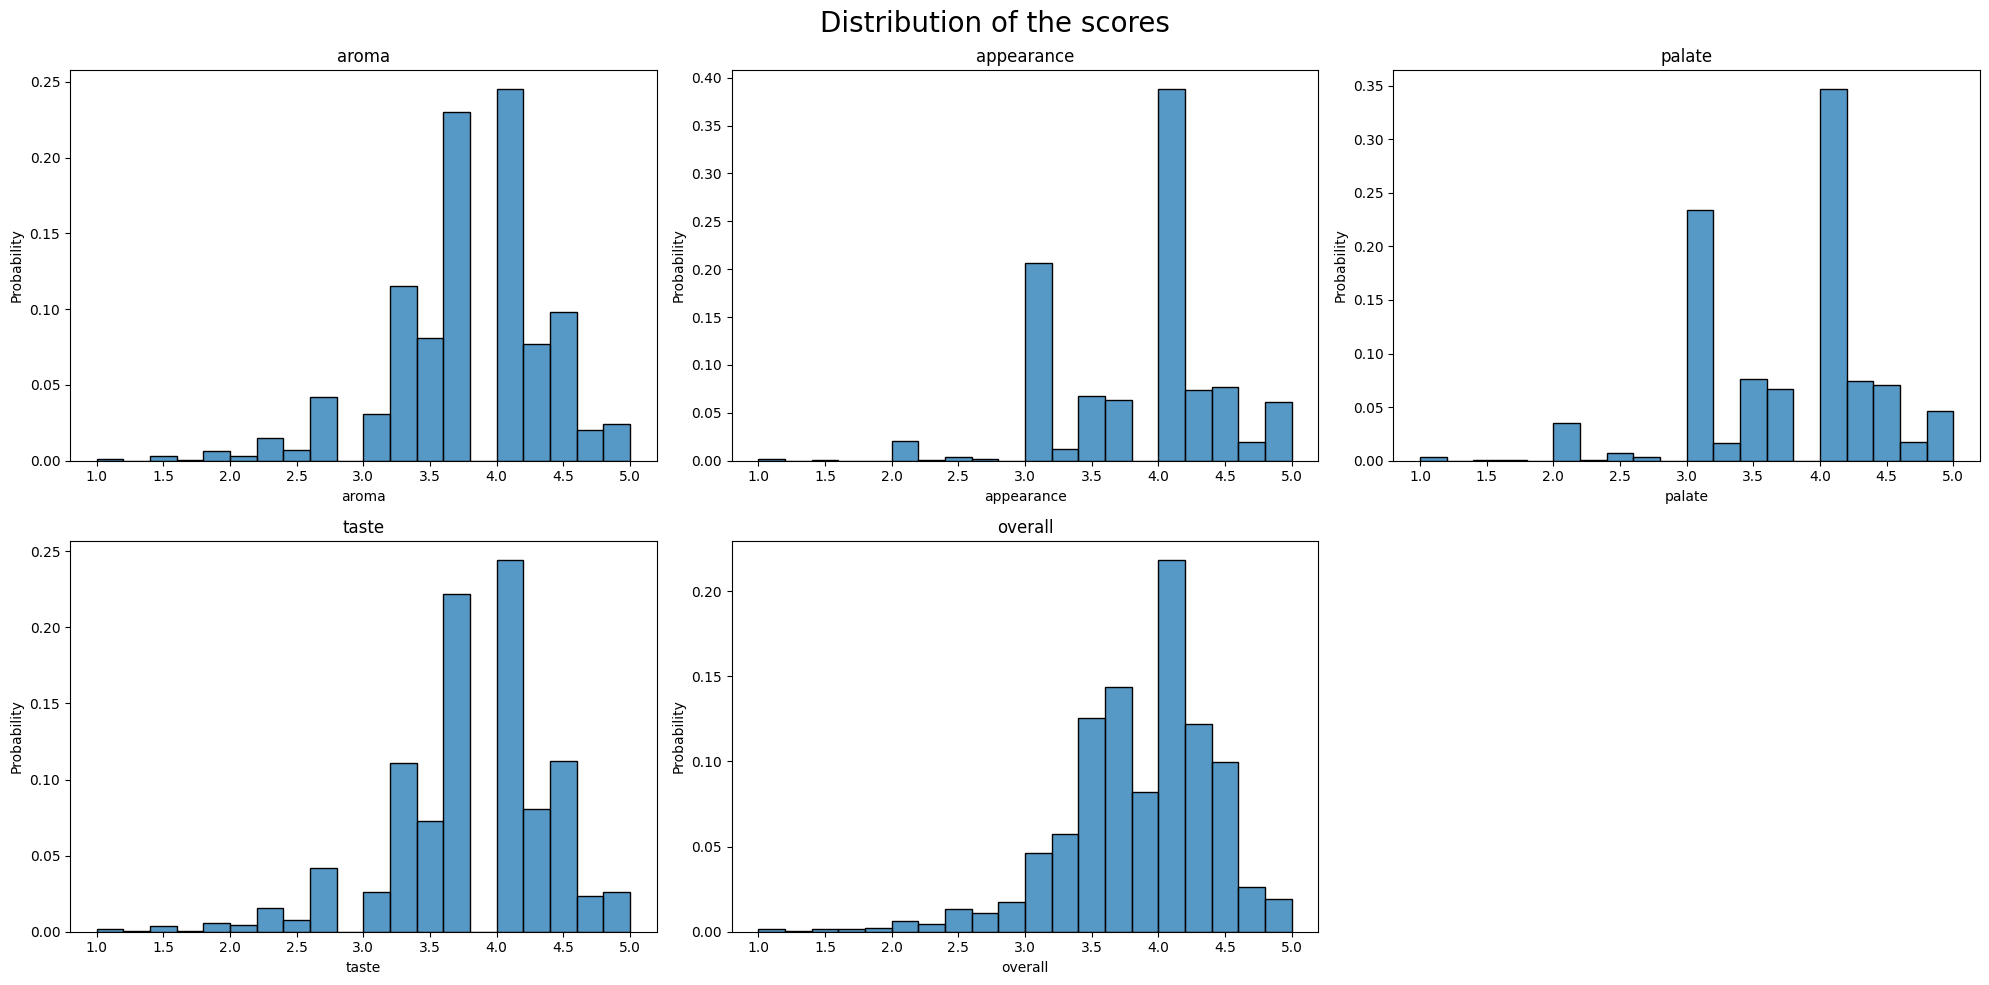

In [7]:
# Compute for each main score the max and min score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

# Plot the distribution of the scores
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    sns.histplot(us_users_ratings[score], ax=ax, stat="probability", bins=20)
    ax.set_title(score)

axs[1][2].set_visible(False)

fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()

The following function is used to help plot the results. 

<span style="color:red">TO MOVE IN SEPARATE FILE</span>

In [8]:
def plot_climate_stats(
    df, column, title, ax=None, symmetrical=False, categorical=False
):
    """



    This function plots on a map of the United States the mean of the column passed as argument for each state depending on its climate.



    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.




    Args:



        df (pd.DataFrame): DataFrame containing the data to plot



        column (str): Column to plot



        title (str): Title of the plot



        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes is created.



        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.



        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """

    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")

    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df

    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")

    us_map = us_map.merge(df, left_on="Climate", right_on="climate")

    # For display purposes, move Alaska and Hawaii to the East

    alaska = us_map[us_map["NAME"] == "Alaska"].geometry

    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)

    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()

    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska

    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii

    # Plot the map

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 7))

    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")

    if symmetrical:
        cmap_name = "RdBu_r"

    elif categorical:
        cmap_name = "tab10"

    else:
        cmap_name = "YlOrRd"

    us_map_shifted.plot(
        column=column,
        cmap=cmap_name,
        ax=ax,
        label=column,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )

    ax.set_title(title)

    ax.set_axis_off()

    ax.set_xlim(-140, -60)

## First analysis:

We are going to groupby the climate of the state and then plot the mean of the ratings. We will also plot the mean of the ratings for the whole United States for comparison. In each step a one-way ANOVA test will be performed to see if the difference is significant in between the different climates.

In [9]:
# Names of the columns of the scores to compare
columns_compare = ["aroma", "appearance", "palate", "taste", "overall"]

First, we compute the mean of the ratings. There are two ways to do so:
- Compute the mean of each reviews directly: the micro average
- Compute the mean of the mean for each climate: the macro average

Both are computed and will be used as a way to compare the results with a baseline.

In [10]:
micro_average_ratings = (
    us_users_ratings[columns_compare].mean().sort_values(ascending=False).reset_index()
)
micro_average_ratings.columns = ["score", "mean"]


display(micro_average_ratings)


# Let's compute statistics for each climate


climate_average_ratings = (
    us_users_ratings.groupby("climate")[columns_compare]
    .mean()
    .sort_values(by="overall", ascending=False)
    .reset_index()
)
climate_average_ratings.set_index("climate", inplace=True)


macro_average_ratings = (
    climate_average_ratings.mean().sort_values(ascending=False).reset_index()
)
macro_average_ratings.columns = ["score", "mean"]


display(macro_average_ratings)

,score,mean
0,overall,3.858160
1,appearance,3.809361
2,taste,3.791102
3,aroma,3.768450
4,palate,3.711874


,score,mean
0,overall,3.834160
1,appearance,3.788386
2,taste,3.751408
3,aroma,3.730139
4,palate,3.676703


Now, for each climate we compute the different scores' average and plot them to compare in between them and with the global average.

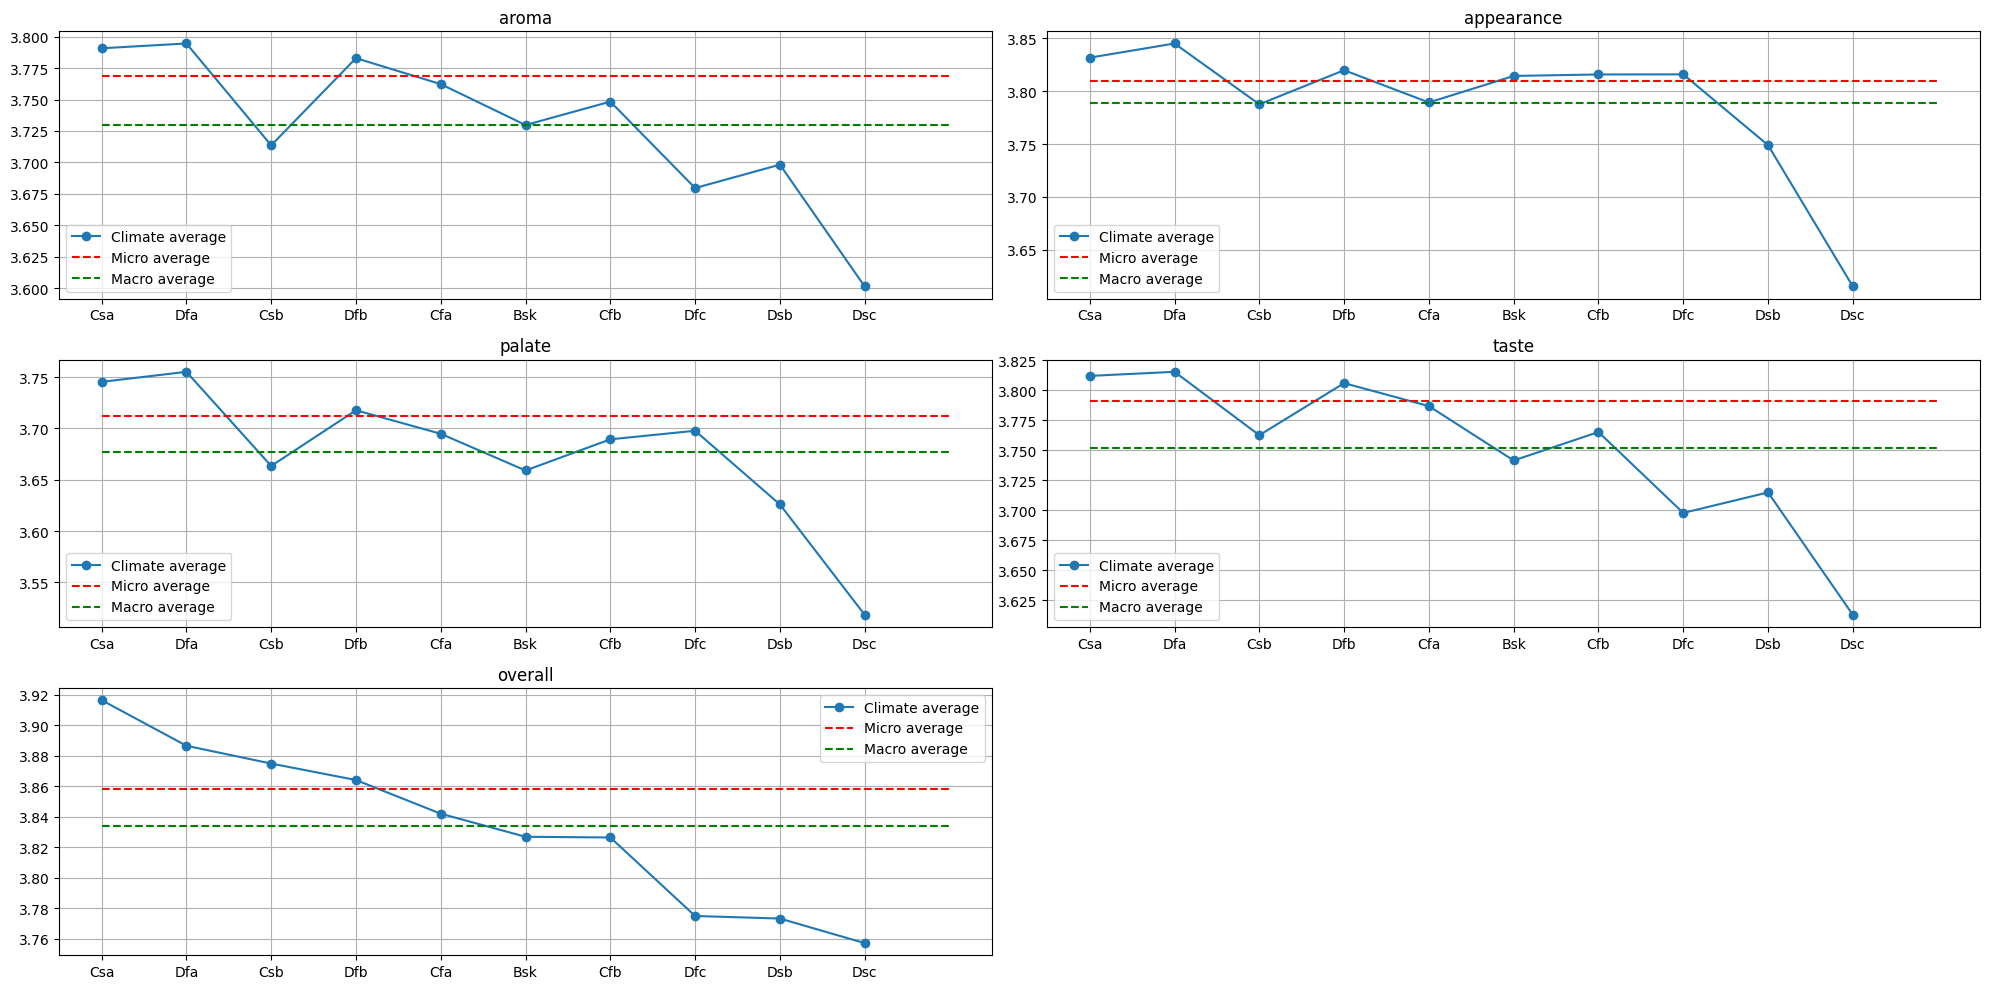

In [11]:
# Plot the different mean as a function of the climate
num_scores = len(columns_compare)

fig, axs = plt.subplots(num_scores // 2 + 1, 2, figsize=(20, 10))

for i in range(num_scores // 2):
    axs[i, 0].plot(
        climate_average_ratings.iloc[:, 2 * i], "o-", label="Climate average"
    )

    micro_average_value = micro_average_ratings[
        micro_average_ratings["score"] == columns_compare[2 * i]
    ]["mean"].values[0]
    macro_average_value = macro_average_ratings[
        macro_average_ratings["score"] == columns_compare[2 * i]
    ]["mean"].values[0]
    axs[i, 0].plot(
        [0, len(climate_average_ratings)],
        [micro_average_value, micro_average_value],
        "r--",
        label="Micro average",
    )
    axs[i, 0].plot(
        [0, len(climate_average_ratings)],
        [macro_average_value, macro_average_value],
        "g--",
        label="Macro average",
    )
    axs[i, 0].set_title(columns_compare[2 * i])
    axs[i, 0].set_xticks(range(len(climate_average_ratings)))
    axs[i, 0].legend()
    axs[i, 0].grid()

    axs[i, 1].plot(
        climate_average_ratings.iloc[:, 2 * i + 1], "o-", label="Climate average"
    )
    micro_average_value = micro_average_ratings[
        micro_average_ratings["score"] == columns_compare[2 * i + 1]
    ]["mean"].values[0]
    macro_average_value = macro_average_ratings[
        macro_average_ratings["score"] == columns_compare[2 * i + 1]
    ]["mean"].values[0]
    axs[i, 1].plot(
        [0, len(climate_average_ratings)],
        [micro_average_value, micro_average_value],
        "r--",
        label="Micro average",
    )
    axs[i, 1].plot(
        [0, len(climate_average_ratings)],
        [macro_average_value, macro_average_value],
        "g--",
        label="Macro average",
    )
    axs[i, 1].set_title(columns_compare[2 * i + 1])
    axs[i, 1].set_xticks(range(len(climate_average_ratings)))
    axs[i, 1].legend()
    axs[i, 1].grid()

axs[num_scores // 2, 0].plot(
    climate_average_ratings.iloc[:, 2 * (num_scores // 2)],
    "o-",
    label="Climate average",
)
micro_average_value = micro_average_ratings[
    micro_average_ratings["score"] == columns_compare[2 * (num_scores // 2)]
]["mean"].values[0]
macro_average_value = macro_average_ratings[
    macro_average_ratings["score"] == columns_compare[2 * (num_scores // 2)]
]["mean"].values[0]
axs[num_scores // 2, 0].plot(
    [0, len(climate_average_ratings)],
    [micro_average_value, micro_average_value],
    "r--",
    label="Micro average",
)
axs[num_scores // 2, 0].plot(
    [0, len(climate_average_ratings)],
    [macro_average_value, macro_average_value],
    "g--",
    label="Macro average",
)
axs[num_scores // 2, 0].set_title(columns_compare[2 * (num_scores // 2)])
axs[num_scores // 2, 0].set_xticks(range(len(climate_average_ratings)))
axs[num_scores // 2, 0].legend()
axs[num_scores // 2, 0].grid()

axs[num_scores // 2, 1].set_visible(False)

plt.tight_layout()
plt.show()

Lookin at the prevous plots it seems that the climate has an impact on the ratings, with a maximum difference of around 0.2. However the difference is still not very big and we need to perform a statistical test to see if the difference is significant. Furthermore, looking at these plots it is hard to interpret anything, we need to decompose the climate into its three components: scheme, precipitation and temperature. Furthemore we can also plot the results on a map to see if there is a geographical pattern.

In [3]:
# Let's do sns.barplot for each score per climate
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(columns_compare)):
    sns.barplot(
        x="climate",
        y=columns_compare[2 * i],
        data=us_users_ratings,
        ax=axs[i // 3, i % 3],
    )
    axs[i // 3, i % 3].set_title(columns_compare[2 * i])
    axs[i // 3, i % 3].tick_params(axis="x", rotation=90)
    axs[i // 3, i % 3].set_ylim(3.5, 4.5)

    sns.barplot(
        x="climate",
        y=columns_compare[2 * i + 1],
        data=us_users_ratings,
        ax=axs[i // 3, i % 3],
    )
    axs[i // 3, i % 3].set_title(columns_compare[2 * i + 1])
    axs[i // 3, i % 3].tick_params(axis="x", rotation=90)
    axs[i // 3, i % 3].set_ylim(3.5, 4.5)

axs[1][2].set_visible(False)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

Let's go in more in-depth analysis of the climate distribution.

First, we can notice that the number of reviews highly variates in between the different climates. This might be a problem for the analysis as the number of reviews is not the same in between the different climates.

In [14]:
# First we can print the number of reviews per climate
print("Number of reviews per climate:")
display(us_users_ratings["climate"].value_counts())

Number of reviews per climate:


climate
Cfa    329893
Dfb    184476
Dfa    160204
Csa     94906
Dsb     31820
Dfc     27793
Csb     15040
Bsk      9551
Dsc      5990
Cfb      3070
Name: count, dtype: int64

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

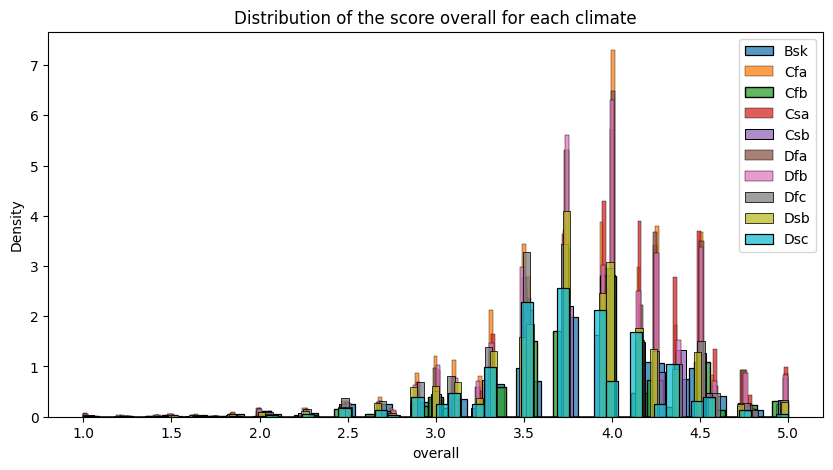

In [15]:
# For one chosen score, plot the distribution of the score for each climate
score = "overall"

# Get the data
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

# Plot the data
box_plot = False
if box_plot:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot(data_to_plot[score])
    ax.set_xticklabels(data_to_plot["climate"])
    ax.set_ylabel(score)
    ax.set_title("Distribution of the score " + score + " for each climate")
else:
    # Use superimposed histograms
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(data_to_plot)):
        sns.histplot(
            data_to_plot[score][i],
            ax=ax,
            label=data_to_plot["climate"][i],
            stat="density",
        )
    ax.set_xlabel(score)
    ax.set_ylabel("Density")
    ax.set_title("Distribution of the score " + score + " for each climate")
    ax.legend()


plt.show()

When we look at the distribution of the different climates, it seems that the distribution are different. However, we need to perform a statistical test to see if the difference is significant.

In [16]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate == zone][score]
            for zone in us_users_ratings.climate.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 0.0
appearance 0.0
palate 0.0
taste 0.0
overall 0.0


For all the scores, the one-way ANOVA test is performed to see if the difference is significant. Each time, the null hypothesis is rejected, meaning that the difference is significant. This indicates that the climate has an impact on the ratings but the results are not very interpretable. We need to decompose the climate into its three components: scheme, precipitation and temperature.

## Second analysis:

In this second analysis, we are going to decompose the climate into its three components: scheme, precipitation and temperature. We will then perform the same analysis as before to see if the difference is significant.

We start with the temperature:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

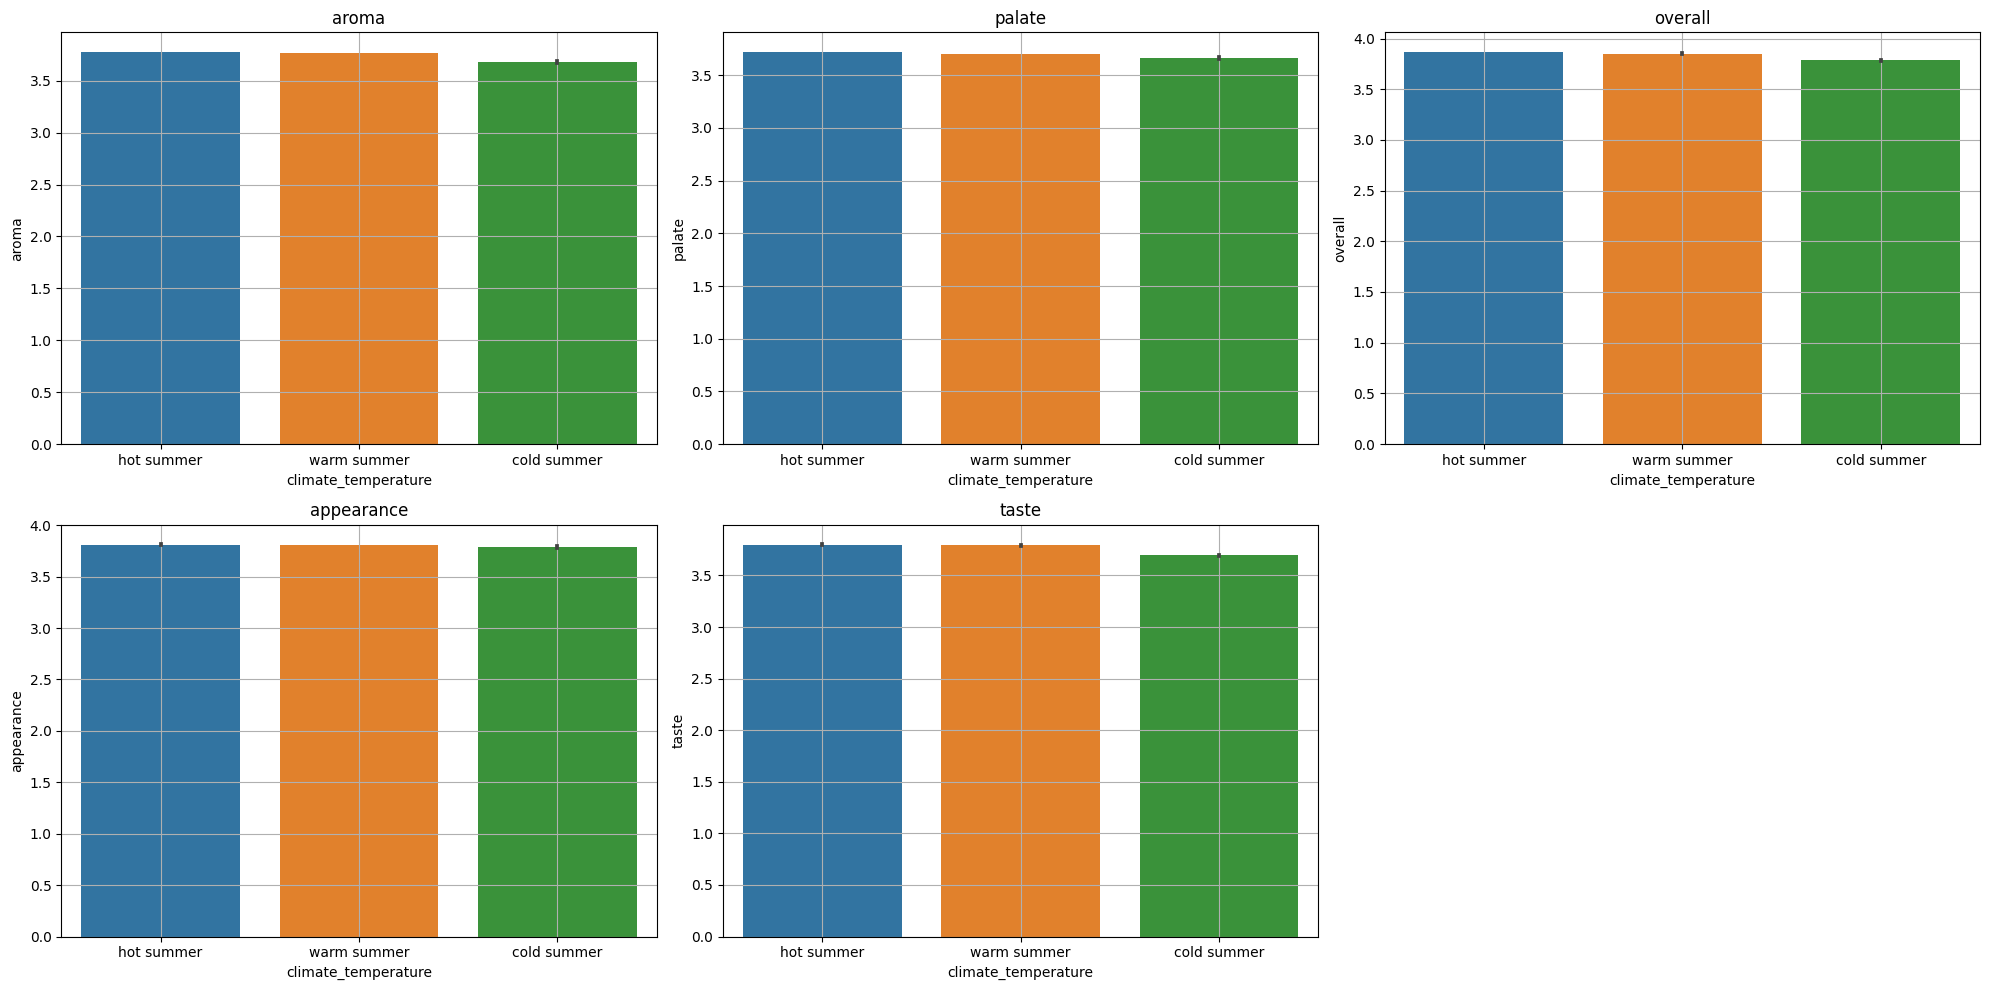

In [17]:
# Plot the average overall score for each climate temp
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    sns.barplot(
        x=us_users_ratings["climate_temperature"],
        y=us_users_ratings[score],
        ax=ax[i % 2, i // 2],
    )
    ax[i % 2, i // 2].set_title(score)
    ax[i % 2, i // 2].grid()

ax[1, 2].axis("off")
plt.tight_layout()
plt.show()

Just looking at these barplots, it does not seem that the temperature has an impact on the ratings. However, we need to perform a statistical test to see if the difference is significant.

In [ ]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_temperature == zone][score]
            for zone in us_users_ratings.climate_temperature.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 3.9275560591256844e-231
appearance 6.533797653554101e-13
palate 4.290667765342083e-74
taste 9.511391804416189e-250
overall 2.2766902754426052e-197


After performing the one-way ANOVA test, we can see that the difference is significant for the temperature. This means that the temperature does have an impact on the ratings. However, the difference is very small as the following plot shows.

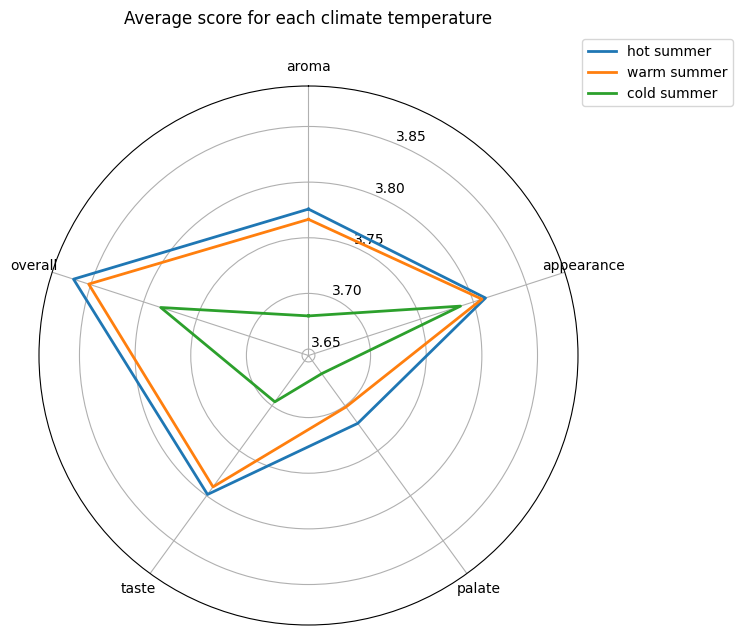

In [22]:
# Now let's analyze but using the climate_temperature column
climate_temperature_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_t in us_users_ratings["climate_temperature"].unique():
    climate_temperature_dfs[climate_t] = us_users_ratings[
        us_users_ratings["climate_temperature"] == climate_t
    ]

    for score in scores_to_compare:
        averages_scores[(climate_t, score)] = climate_temperature_dfs[climate_t][
            score
        ].mean()

# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in us_users_ratings["climate_temperature"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])

    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(
    min_average_score - 0.1 * diff_average_score,
    max_average_score + 0.1 * diff_average_score,
)

# Set the title
ax.set_title("Average score for each climate temperature", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

Here a similar analysis is performed for the precipitation:

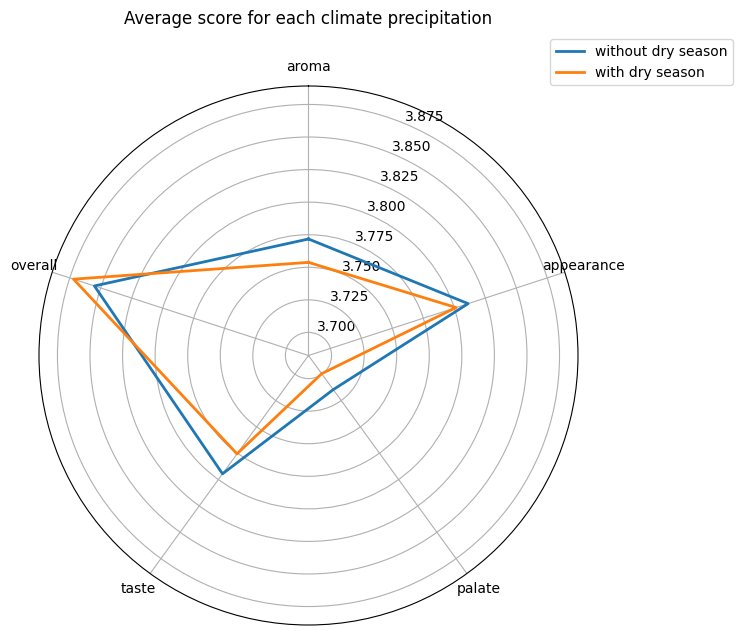

In [24]:
# Now let's analyze but using the climate_temperature column
climate_precipitation_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_prec in us_users_ratings["climate_precipitation"].unique():
    climate_precipitation_dfs[climate_prec] = us_users_ratings[
        us_users_ratings["climate_precipitation"] == climate_prec
    ]

    for score in scores_to_compare:
        averages_scores[(climate_prec, score)] = climate_precipitation_dfs[
            climate_prec
        ][score].mean()

# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in us_users_ratings["climate_precipitation"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])

    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(
    min_average_score - 0.1 * diff_average_score,
    max_average_score + 0.1 * diff_average_score,
)

# Set the title
ax.set_title("Average score for each climate precipitation", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

With the following p-values:

In [25]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_precipitation == zone][score]
            for zone in us_users_ratings.climate_precipitation.unique()
        ],
        axis=0
    )

    print(score, res[1])

aroma 1.826238705456336e-27
appearance 6.047862157396129e-08
palate 2.188714498785996e-15
taste 1.1237054531250214e-28
overall 7.011835650552108e-27


Finally, the same analysis is performed for the scheme:

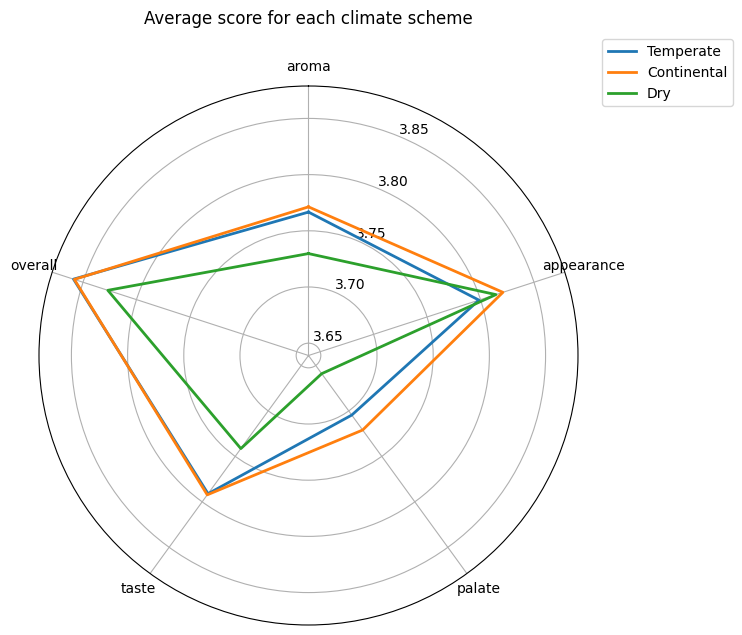

In [35]:
# Now let's analyze but using the climate_scheme column
climate_scheme_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_s in us_users_ratings["climate_scheme"].unique():
    climate_scheme_dfs[climate_s] = us_users_ratings[
        us_users_ratings["climate_scheme"] == climate_s
    ]

    for score in scores_to_compare:
        averages_scores[(climate_s, score)] = climate_scheme_dfs[climate_s][
            score
        ].mean()

# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in us_users_ratings["climate_scheme"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])

    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(
    min_average_score - 0.1 * diff_average_score,
    max_average_score + 0.1 * diff_average_score,
)

# Set the title
ax.set_title("Average score for each climate scheme", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

In [36]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_scheme == zone][score]
            for zone in us_users_ratings.climate_scheme.unique()
        ],
        axis=0
    )

    print(score, res[1])

aroma 1.6617544140786726e-12
appearance 1.9712082985803656e-57
palate 4.153030103535449e-40
taste 8.740468335523494e-15
overall 2.4814665610875236e-07


From the previous results, it appears that indeed climate have a small impact on the appreciation of the beers. However, the difference is very small.

To go more in details, we are now going to study the different beers, mostly which type of beers are liked in the various climates.
